In [4]:
## Ce module permet de faire une visualisation des données
import pandas as pd
import numpy as np
import sklearn.metrics as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from glob import glob
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
import time


def complete(text, state):
    return (glob.glob(text+'*')+[None])[state]

def showMatrix(data,title):
    corr=data.corr()
    #print (corr)
    plt.title(title)
    plt.figure(figsize=(25,25))
    sns.heatmap(corr, annot=True,fmt=".1f")
    plt.tight_layout()
    plt.show()

def getInfo(data):
    print("Les dimensions: ",data.shape)
    print(data.head())
    print(data.info())


In [5]:
def train_split(data):
    X_train=data.drop(['attack_cat'], axis=1)
    y_train=data['attack_cat']
    return X_train,y_train

data_train = pd.read_csv('./UNSW_NB15_training-set_selected.csv').drop([ 'id','label'], axis=1)

X_train,Y_train = train_split(data_train)
#print(Counter(Y_train))

In [19]:
def train_split_b(data):
    X_train=data.drop(['label'], axis=1)
    y_train=data['label']
    return X_train,y_train

data_train_b = pd.read_csv('./UNSW_NB15_training-set_selected.csv').drop([ 'id', 'attack_cat'], axis=1)
#data_test = pd.read_csv('./UNSW_NB15_testing-set.csv').drop([ 'id', 'label'], axis=1)

X_train_b,Y_train_b = train_split_b(data_train_b)

In [3]:
data_train.dtypes

dur                  float64
proto                 object
service               object
state                 object
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
synack               float64
ackdat               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl           int64
ct_dst_ltm             int64
ct_src_dport_ltm       int64
ct_dst_sport_l

In [6]:

X_train['proto']=LabelEncoder().fit_transform(X_train['proto'])
X_train['service']=LabelEncoder().fit_transform(X_train['service'])
X_train['state']=LabelEncoder().fit_transform(X_train['state'])
Y_train_en=LabelEncoder().fit_transform(Y_train)
#print(X_train.head())
cat_columns = ['attack_cat']
Y_train_ohe = pd.get_dummies(Y_train, prefix_sep="__",
                                columns=cat_columns)

#print(Y_train_ohe.head())
data_sc = pd.concat([X_train,Y_train_ohe], axis=1, sort=False)

In [22]:
X_train_b['proto']=LabelEncoder().fit_transform(X_train_b['proto'])
X_train_b['service']=LabelEncoder().fit_transform(X_train_b['service'])
X_train_b['state']=LabelEncoder().fit_transform(X_train_b['state'])
Y_train_b_en=pd.DataFrame(LabelEncoder().fit_transform(Y_train_b))

#print(Y_train_ohe.head())
data_sc_b = pd.concat([X_train_b,Y_train_b_en], axis=1, sort=False)

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
sc = StandardScaler()
X_train_1 = pd.DataFrame(sc.fit_transform(X_train))

X_train_1=X_train_1.replace([np.Inf, np.NINF], np.nan).dropna()
pca = PCA(n_components=10)
pca.fit(X_train_1)
lda = LDA(n_components=10, shrinkage='auto', solver='eigen') 
X_lda = lda.fit_transform(X_train_1, Y_train_en  )
X_train_pca = pca.fit_transform(X_train_1)

/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(42, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit

X_train_pca = pca.transform(X_train_1)
X_train_sc1=X_train_pca
Y_train_1=Y_train_en
X_train_sc, X_test_sc, Y_train_enl, Y_test_en = train_test_split(X_train_sc1, Y_train_1, test_size=0.1)

param_grid = {'max_depth': [ 800], 'n_estimators': [ 500]}
randomForest_clf = RandomForestClassifier()
grid_search = GridSearchCV(randomForest_clf, param_grid, cv=10, scoring='neg_mean_squared_error')
start = time. time()
grid_search.fit(X_train_sc, Y_train_enl)
end = time. time()
clf1 = grid_search.best_estimator_
print("train accuracy: ", accuracy_score(Y_train_enl, clf1.predict(X_train_sc)))
y_pred_RF = clf1.predict(X_test_sc)
RF_time=end - start
print("Time MC: ",RF_time)
accuracy_means_score_RF=accuracy_score(Y_test_en, y_pred_RF)
precision_score_RF=precision_score(Y_test_en, y_pred_RF, average=None)
recall_score_RF=recall_score(Y_test_en, y_pred_RF, average=None)
precision_mean_score_RF=precision_score(Y_test_en, y_pred_RF, average="micro")
print("test average accuracy: ",accuracy_means_score_RF )
print("test precision: ", precision_score_RF)
print("test micro-average precision: ",precision_mean_score_RF )
print("test recall: ",recall_score_RF )

train accuracy:  0.9372182784960458
Time MC:  1174.3711063861847
test average accuracy:  0.8192858877823658
test precision:  [0.75       1.         0.3556701  0.60652921 0.48372093 0.99571275
 0.88096988 0.79928315 0.63157895 0.        ]
test micro-average precision:  0.8192858877823658
test recall:  [0.04347826 0.01886792 0.33414044 0.65430955 0.33986928 0.97379455
 0.97347767 0.59946237 0.375      0.        ]


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit

X_train_sc1=X_lda
Y_train_1=Y_train_en
X_train_sc, X_test_sc, Y_train_enl, Y_test_en = train_test_split(X_train_sc1, Y_train_1, test_size=0.1)

param_grid = {'max_depth': [ 800], 'n_estimators': [ 500]}
randomForest_clf = RandomForestClassifier()
grid_search = GridSearchCV(randomForest_clf, param_grid, cv=10, scoring='neg_mean_squared_error')
start = time. time()
grid_search.fit(X_train_sc, Y_train_enl)
end = time. time()
clf1 = grid_search.best_estimator_
print("train accuracy: ", accuracy_score(Y_train_enl, clf1.predict(X_train_sc)))
y_pred_RF = clf1.predict(X_test_sc)
RF_time=end - start
print("Time MC: ",RF_time)
accuracy_means_score_RF=accuracy_score(Y_test_en, y_pred_RF)
precision_score_RF=precision_score(Y_test_en, y_pred_RF, average=None)
recall_score_RF=recall_score(Y_test_en, y_pred_RF, average=None)
precision_mean_score_RF=precision_score(Y_test_en, y_pred_RF, average="micro")
print("test average accuracy: ",accuracy_means_score_RF )
print("test precision: ", precision_score_RF)
print("test micro-average precision: ",precision_mean_score_RF )
print("test recall: ",recall_score_RF )

train accuracy:  0.9376096520823773
Time MC:  1099.4802231788635
test average accuracy:  0.8367743502550401
test precision:  [0.6        0.         0.37717122 0.6222935  0.61262799 0.99559471
 0.91818883 0.77978339 0.58333333 0.        ]
test micro-average precision:  0.8367743502550401
test recall:  [0.03614458 0.         0.38287154 0.66495287 0.5600624  0.969437
 0.97888097 0.63716814 0.22580645 0.        ]


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [5]:

print(data_sc.describe())
print(data_sc.shape)
print(Y_train_ohe.shape)

                dur         proto       service         state         spkts  \
count  82332.000000  82332.000000  82332.000000  82332.000000  82332.000000   
mean       1.006756    109.348273      1.421695      3.374751     18.666472   
std        4.710444     18.637282      2.108083      0.670372    133.916353   
min        0.000000      0.000000      0.000000      0.000000      1.000000   
25%        0.000008    111.000000      0.000000      3.000000      2.000000   
50%        0.014138    111.000000      0.000000      3.000000      6.000000   
75%        0.719360    117.000000      2.000000      4.000000     12.000000   
max       59.999989    130.000000     12.000000      6.000000  10646.000000   

              dpkts        sbytes        dbytes          rate          sttl  \
count  82332.000000  8.233200e+04  8.233200e+04  8.233200e+04  82332.000000   
mean      17.545936  7.993908e+03  1.323379e+04  8.241089e+04    180.967667   
std      115.574086  1.716423e+05  1.514715e+05  1.

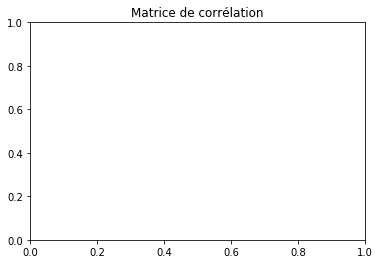

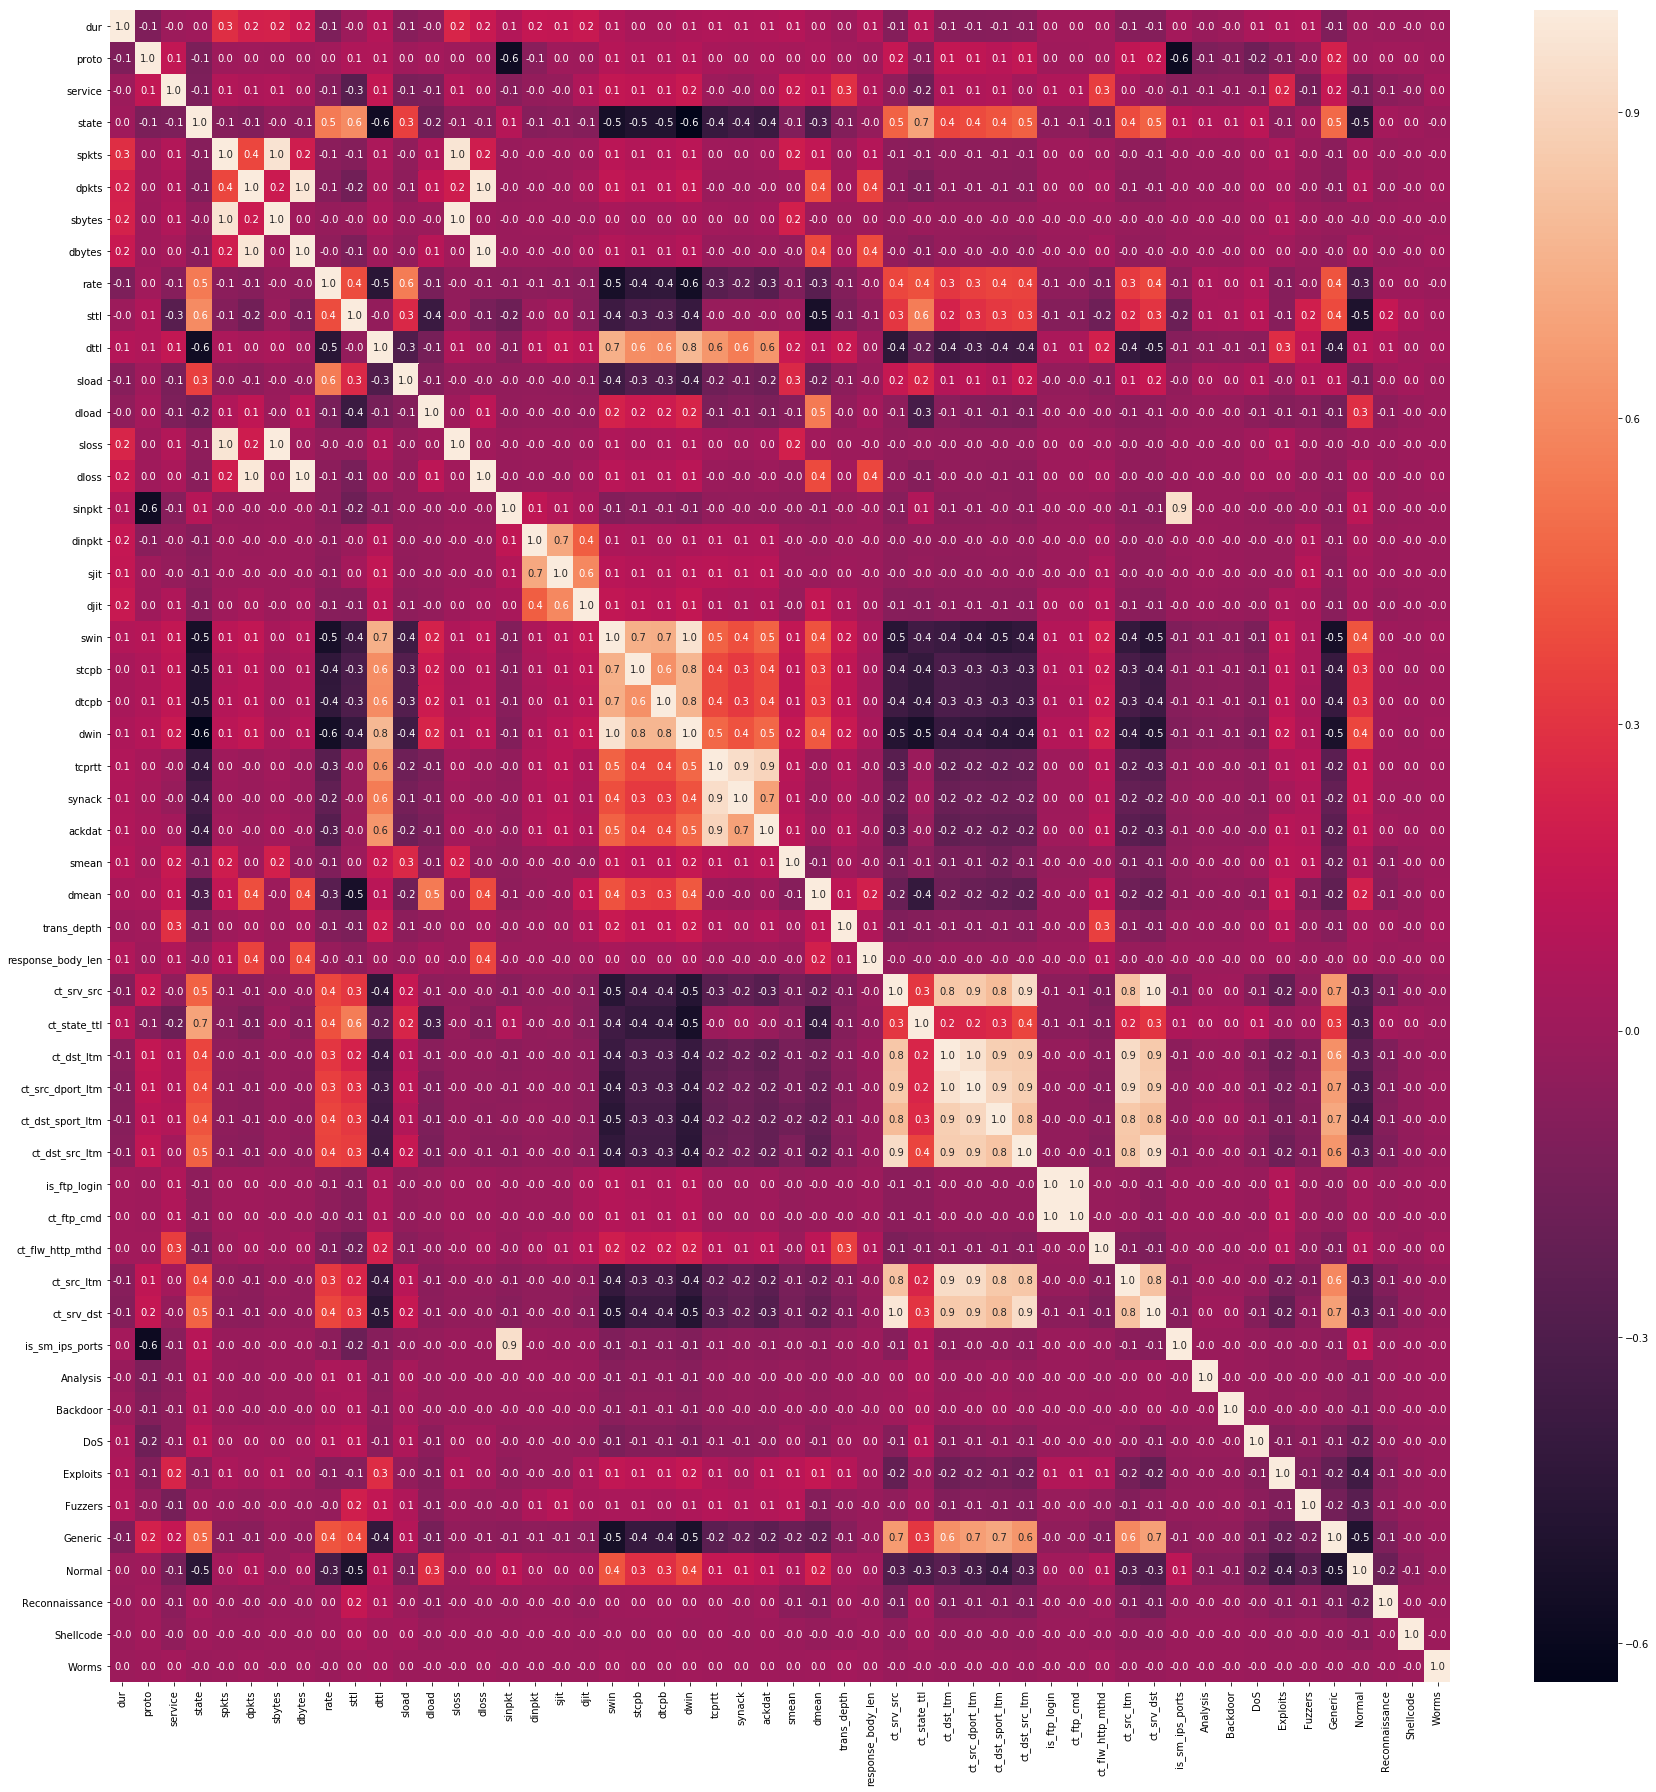

In [35]:
showMatrix(data_sc,"Matrice de corrélation")

In [7]:
from sklearn.preprocessing import MinMaxScaler

X_train_nor=pd.DataFrame(MinMaxScaler().fit_transform(X_train),columns=list(X_train))
data_sc_nor=pd.DataFrame(MinMaxScaler().fit_transform(data_sc),columns=list(data_sc))
#showMatrix(data_sc_nor,"Matrice de corrélation normalisée")

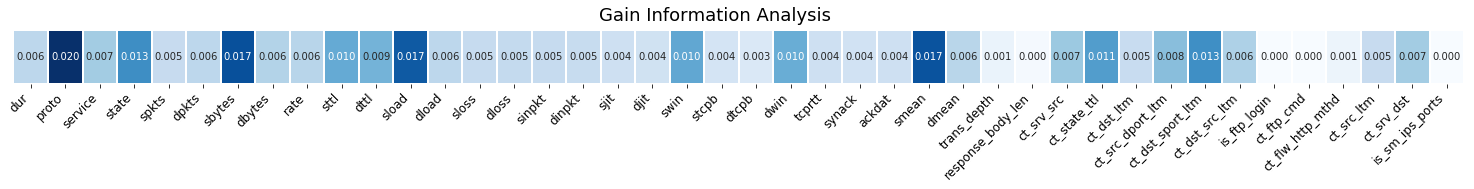

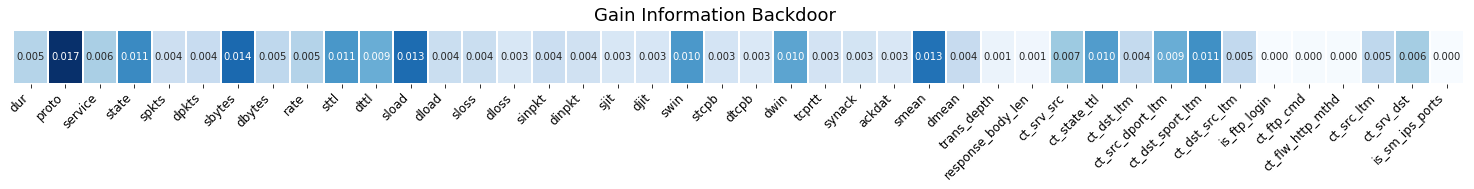

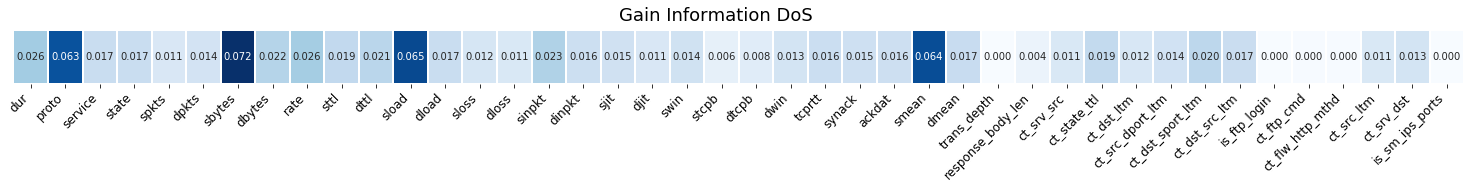

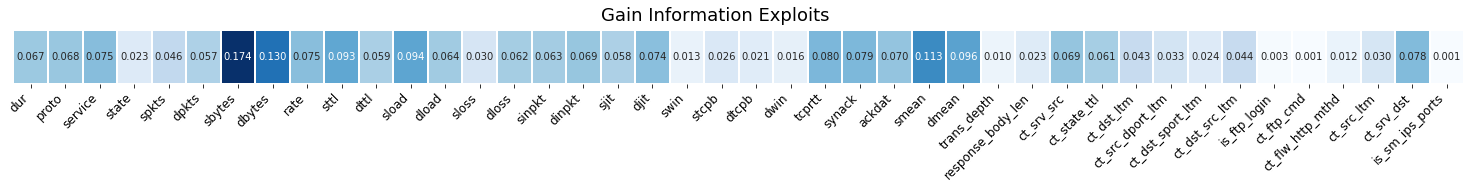

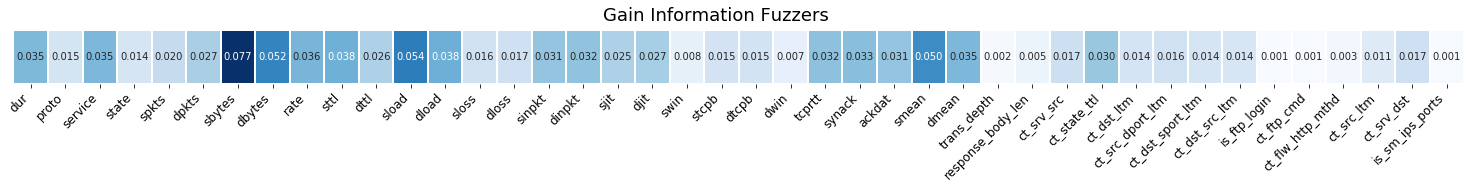

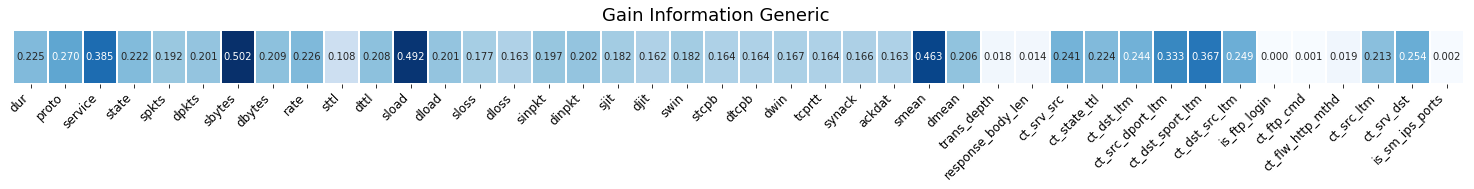

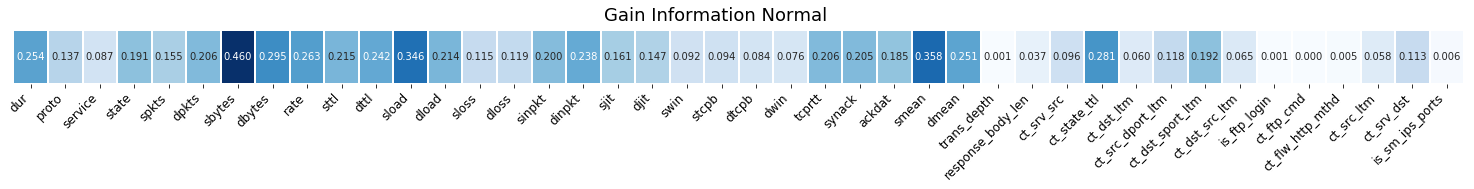

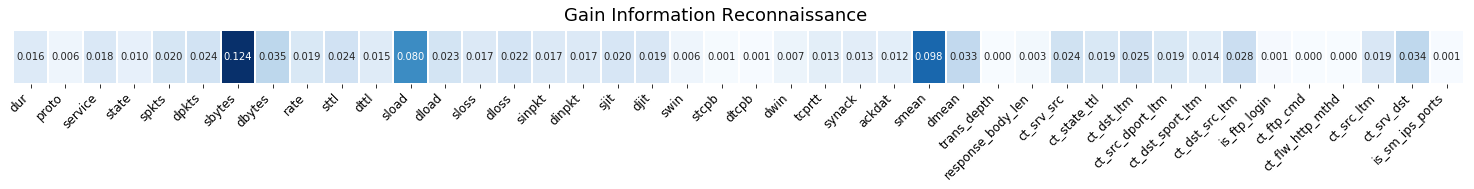

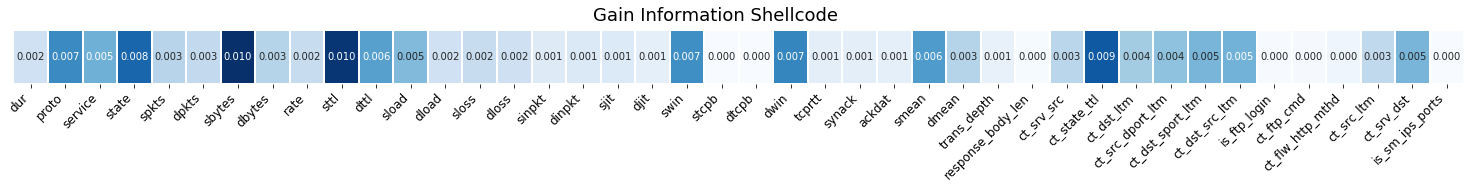

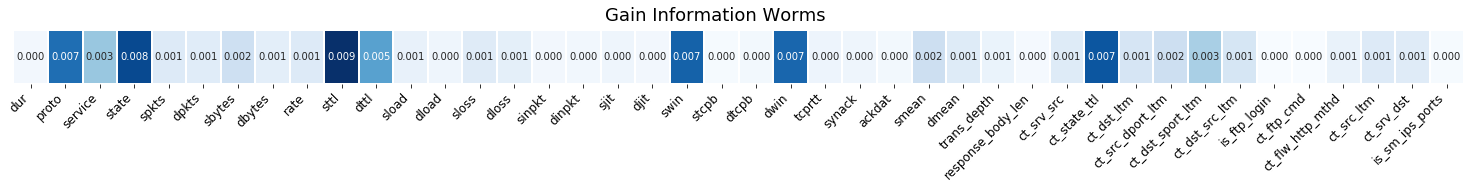

In [64]:
for c in Y_train_ohe:
    GI = mutual_info_classif(X_train, Y_train_ohe[c])

    plt.subplots(1, figsize=(26, 1))
    sns.heatmap(GI[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True,fmt=".3f")
    plt.yticks([], [])
    plt.gca().set_xticklabels(X_train.columns, rotation=45, ha='right', fontsize=12)
    plt.suptitle("Gain Information "+c, fontsize=18, y=1.2)
    plt.gcf().subplots_adjust(wspace=0.2)
    plt.show()

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit

X_train_sc1=X_train_nor
Y_train_1=Y_train_en
X_train_sc, X_test_sc, Y_train_enl, Y_test_en = train_test_split(X_train_sc1, Y_train_1, test_size=0.1)

param_grid = {'max_depth': [ 800, 1000], 'n_estimators': [ 500,400, 600]}
randomForest_clf = RandomForestClassifier()
grid_search = GridSearchCV(randomForest_clf, param_grid, cv=10, scoring='neg_mean_squared_error')
start = time. time()
grid_search.fit(X_train_sc, Y_train_enl)
end = time. time()
clf1 = grid_search.best_estimator_
print("train accuracy: ", accuracy_score(Y_train_enl, clf1.predict(X_train_sc)))
y_pred_RF = clf1.predict(X_test_sc)
RF_time=end - start
print("Time MC: ",RF_time)
accuracy_means_score_RF=accuracy_score(Y_test_en, y_pred_RF)
precision_score_RF=precision_score(Y_test_en, y_pred_RF, average=None)
recall_score_RF=recall_score(Y_test_en, y_pred_RF, average=None)
precision_mean_score_RF=precision_score(Y_test_en, y_pred_RF, average="micro")
print("test average accuracy: ",accuracy_means_score_RF )
print("test precision: ", precision_score_RF)
print("test micro-average precision: ",precision_mean_score_RF )
print("test recall: ",recall_score_RF )
    

train accuracy:  0.9371238090096898
Time MC:  10482.915075540543
test average accuracy:  0.8702939033276658
test precision:  [1.         0.4        0.44622426 0.64233577 0.69628433 0.9939792
 0.96186218 0.91272727 0.6        0.        ]
test micro-average precision:  0.8702939033276658
test recall:  [0.01612903 0.03030303 0.43624161 0.71287129 0.67449139 0.97581945
 0.99025183 0.78930818 0.63636364 0.        ]


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
    GI = mutual_info_classif(X_train_b, Y_train_b_en)
    resultat=pd.DataFrame(GI,index=X_train_b.columns)
    resultat=resultat.sort_values(by = 0, ascending = False)
    print(resultat)
    X_train_sc1=X_train_nor[resultat.index[0:10]]
    X_train_sc, X_test_sc, Y_train_enl, Y_test_en = train_test_split(X_train_sc1, Y_train_1, test_size=0.1)

    param_grid = {'max_depth': [ 800, 1000], 'n_estimators': [ 500,400, 600]}
    randomForest_clf = RandomForestClassifier()
    grid_search = GridSearchCV(randomForest_clf, param_grid, cv=10, scoring='neg_mean_squared_error')
    start = time. time()
    grid_search.fit(X_train_sc, Y_train_enl)
    end = time. time()
    clf1 = grid_search.best_estimator_
    print("train accuracy: ", accuracy_score(Y_train_enl, clf1.predict(X_train_sc)))
    y_pred_RF = clf1.predict(X_test_sc)
    RF_time=end - start
    print("Time MC: ",RF_time)
    accuracy_means_score_RF=accuracy_score(Y_test_en, y_pred_RF)
    precision_score_RF=precision_score(Y_test_en, y_pred_RF, average=None)
    recall_score_RF=recall_score(Y_test_en, y_pred_RF, average=None)
    precision_mean_score_RF=precision_score(Y_test_en, y_pred_RF, average="micro")
    print("test average accuracy: ",accuracy_means_score_RF )
    print("test precision: ", precision_score_RF)
    print("test micro-average precision: ",precision_mean_score_RF )
    print("test recall: ",recall_score_RF )

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                          0
sbytes             0.461213
smean              0.357766
sload              0.345459
dbytes             0.292599
ct_state_ttl       0.282324
rate               0.263445
dur                0.254144
dmean              0.250776
dttl               0.241798
dinpkt             0.238768
sttl               0.216107
dload              0.214135
dpkts              0.208382
tcprtt             0.206053
synack             0.205297
sinpkt             0.199328
state              0.191012
ct_dst_sport_ltm   0.188898
ackdat             0.184286
sjit               0.161510
spkts              0.149314
djit               0.144842
proto              0.140900
dloss              0.117260
ct_src_dport_ltm   0.116884
ct_srv_dst         0.115511
sloss              0.112509
ct_srv_src         0.096360
stcpb              0.090458
swin               0.087935
service            0.085730
dtcpb              0.082933
dwin               0.076782
ct_dst_src_ltm     0.068852
ct_dst_ltm         0

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
for c in Y_train_ohe:
    print(c)
    GI = mutual_info_classif(X_train, Y_train_ohe[c])
    resultat=pd.DataFrame(GI,index=X_train.columns)
    resultat=resultat.sort_values(by = 0, ascending = False)
    X_train_sc1=X_train_nor[resultat.index[0:10]]
    X_train_sc, X_test_sc, Y_train_enl, Y_test_en = train_test_split(X_train_sc1, Y_train_1, test_size=0.1)

    param_grid = {'max_depth': [ 800, 1000], 'n_estimators': [ 500,400, 600]}
    randomForest_clf = RandomForestClassifier()
    grid_search = GridSearchCV(randomForest_clf, param_grid, cv=10, scoring='neg_mean_squared_error')
    start = time. time()
    grid_search.fit(X_train_sc, Y_train_enl)
    end = time. time()
    clf1 = grid_search.best_estimator_
    print("train accuracy: ", accuracy_score(Y_train_enl, clf1.predict(X_train_sc)))
    y_pred_RF = clf1.predict(X_test_sc)
    RF_time=end - start
    print("Time MC: ",RF_time)
    accuracy_means_score_RF=accuracy_score(Y_test_en, y_pred_RF)
    precision_score_RF=precision_score(Y_test_en, y_pred_RF, average=None)
    recall_score_RF=recall_score(Y_test_en, y_pred_RF, average=None)
    precision_mean_score_RF=precision_score(Y_test_en, y_pred_RF, average="micro")
    print("test average accuracy: ",accuracy_means_score_RF )
    print("test precision: ", precision_score_RF)
    print("test micro-average precision: ",precision_mean_score_RF )
    print("test recall: ",recall_score_RF )
    


Analysis
train accuracy:  0.8939107668223164
Time MC:  1148.9855632781982
test average accuracy:  0.8252368229293174
test precision:  [0.         0.33333333 0.39460784 0.62659847 0.45474614 0.99147576
 0.89185783 0.884375   0.26923077 0.5       ]
test micro-average precision:  0.8252368229293174
test recall:  [0.         0.03225806 0.38151659 0.65625    0.34797297 0.97587834
 0.96115186 0.80169972 0.2        0.4       ]
Backdoor


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train accuracy:  0.8940052363086723
Time MC:  1166.2139029502869
test average accuracy:  0.8230507651202332
test precision:  [0.         0.         0.36518047 0.64673913 0.46136364 0.99131379
 0.88572842 0.89677419 0.2        0.        ]
test micro-average precision:  0.8230507651202332
test recall:  [0.         0.         0.45744681 0.63018535 0.31818182 0.97699304
 0.9691475  0.78309859 0.08823529 0.        ]
DoS
train accuracy:  0.9263677832060244
Time MC:  2137.392377138138
test average accuracy:  0.8353169783823172
test precision:  [0.         0.66666667 0.38617886 0.66637555 0.44849785 0.9950495
 0.91020818 0.89735099 0.23809524 0.        ]
test micro-average precision:  0.8353169783823172
test recall:  [0.         0.03174603 0.50131926 0.6923775  0.35244519 0.9788961
 0.95751979 0.75487465 0.12820513 0.        ]
Exploits


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train accuracy:  0.9320629436691948
Time MC:  2219.672445297241
test average accuracy:  0.8514695166383289
test precision:  [0.25       1.         0.44040404 0.68047337 0.54657293 0.99515347
 0.93161494 0.91836735 0.52173913 0.5       ]
test micro-average precision:  0.8514695166383289
test recall:  [0.01515152 0.01666667 0.50697674 0.71365248 0.50816993 0.97519789
 0.96670306 0.78034682 0.46153846 0.42857143]
Fuzzers
train accuracy:  0.9224135604199843
Time MC:  2109.691008090973
test average accuracy:  0.8438183143065339
test precision:  [0.8        0.42857143 0.39037433 0.6484318  0.54299754 0.99345692
 0.91702945 0.88673139 0.31578947 0.66666667]
test micro-average precision:  0.8438183143065339
test recall:  [0.05970149 0.05660377 0.3832021  0.77103209 0.36710963 0.97642015
 0.95646368 0.83030303 0.1875     0.33333333]
Generic
train accuracy:  0.9292423547194256
Time MC:  1578.651388168335
test average accuracy:  0.8577847947534613
test precision:  [1.         0.16666667 0.4044444

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train accuracy:  0.9350319846689519
Time MC:  1571.5702080726624
test average accuracy:  0.875516152538256
test precision:  [1.         1.         0.44308943 0.68329177 0.68330733 0.99341744
 0.9665686  0.94482759 0.6        1.        ]
test micro-average precision:  0.875516152538256
test recall:  [0.09210526 0.04918033 0.53041363 0.71790393 0.70304976 0.97997835
 0.98259924 0.77620397 0.58333333 0.33333333]
Shellcode
train accuracy:  0.8603606035250614
Time MC:  846.796523809433
test average accuracy:  0.8235365557444742
test precision:  [1.         0.66666667 0.27234043 0.57721873 0.59124088 0.98517734
 0.87848164 0.92258065 0.38461538 0.625     ]
test micro-average precision:  0.8235365557444742
test recall:  [0.01492537 0.03389831 0.17204301 0.7598896  0.25673534 0.97587834
 0.96116505 0.78571429 0.32258065 0.625     ]
Worms
train accuracy:  0.8572970930389484
Time MC:  847.5536534786224
test average accuracy:  0.8161282487247996
test precision:  [1.         0.         0.37874659 

In [73]:
x_train=X_train[resultat.index[0:10]]
print(x_train)

KeyError: "['Worms'] not in index"

In [28]:
data_corr=data_sc.corr()
for c in Y_train_ohe:
    data_corr=data_corr.drop([c], axis=0)
for c in Y_train_ohe:
    resultat=data_corr[c]
    #print(resultat)
    resultat=resultat.sort_values( ascending = False)
    print(c)
    X_train_sc1=X_train_nor[resultat.index[1:11]]
    print(resultat.index[0:10])
    X_train_sc, X_test_sc, Y_train_enl, Y_test_en = train_test_split(X_train_sc1, Y_train_1, test_size=0.1)

    param_grid = {'max_depth': [ 800, 1000], 'n_estimators': [ 500,400, 600]}
    randomForest_clf = RandomForestClassifier()
    grid_search = GridSearchCV(randomForest_clf, param_grid, cv=10, scoring='neg_mean_squared_error')
    start = time. time()
    grid_search.fit(X_train_sc, Y_train_enl)
    end = time. time()
    clf1 = grid_search.best_estimator_
    print("train accuracy: ", accuracy_score(Y_train_enl, clf1.predict(X_train_sc)))
    y_pred_RF = clf1.predict(X_test_sc)
    RF_time=end - start
    print("Time MC: ",RF_time)
    accuracy_means_score_RF=accuracy_score(Y_test_en, y_pred_RF)
    precision_score_RF=precision_score(Y_test_en, y_pred_RF, average=None)
    recall_score_RF=recall_score(Y_test_en, y_pred_RF, average=None)
    precision_mean_score_RF=precision_score(Y_test_en, y_pred_RF, average="micro")
    print("test average accuracy: ",accuracy_means_score_RF )
    print("test precision: ", precision_score_RF)
    print("test micro-average precision: ",precision_mean_score_RF )
    print("test recall: ",recall_score_RF )
    #print(resultat)

Analysis
Index(['state', 'rate', 'sttl', 'ct_state_ttl', 'sload', 'ct_srv_src',
       'ct_srv_dst', 'ct_dst_sport_ltm', 'sjit', 'response_body_len'],
      dtype='object')
train accuracy:  0.9336419336554292
Time MC:  5406.176704406738
test average accuracy:  0.8434539713383532
test precision:  [1.         0.         0.4047619  0.65433213 0.54832347 0.99364743
 0.91733196 0.8961039  0.62962963 1.        ]
test micro-average precision:  0.8434539713383532
test recall:  [0.09433962 0.         0.53125    0.66943675 0.44126984 0.96752577
 0.96400541 0.78632479 0.44736842 0.25      ]
Backdoor
Index(['state', 'sttl', 'ct_state_ttl', 'rate', 'sload', 'ct_srv_src',
       'ct_srv_dst', 'ct_dst_sport_ltm', 'dur', 'response_body_len'],
      dtype='object')
train accuracy:  0.9325892736646063
Time MC:  1883.4765348434448
test average accuracy:  0.8443041049307748
test precision:  [1.         0.         0.42406312 0.67688022 0.5202109  0.99395272
 0.92124166 0.86746988 0.73913043 0.5       ]
tes

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train accuracy:  0.910537396420956
Time MC:  1757.0888352394104
test average accuracy:  0.8388389604080642
test precision:  [0.         1.         0.44488978 0.64891041 0.55988024 0.99246096
 0.89896438 0.89375    0.13636364 0.        ]
test micro-average precision:  0.8388389604080642
test recall:  [0.         0.04477612 0.54278729 0.74790698 0.30406504 0.97979798
 0.96007553 0.79665738 0.06666667 0.        ]
Exploits
Index(['dttl', 'service', 'dwin', 'dmean', 'swin', 'stcpb', 'dtcpb', 'smean',
       'ackdat', 'trans_depth'],
      dtype='object')


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train accuracy:  0.9170962779022376
Time MC:  1803.6011910438538
test average accuracy:  0.8260869565217391
test precision:  [0.6        0.85714286 0.54285714 0.57208238 0.61454545 0.98881193
 0.87665647 0.90967742 0.44444444 0.        ]
test micro-average precision:  0.8260869565217391
test recall:  [0.04109589 0.08450704 0.08796296 0.85397096 0.2704     0.97274633
 0.9633156  0.82215743 0.22857143 0.        ]
Fuzzers
Index(['sttl', 'dttl', 'smean', 'sjit', 'tcprtt', 'ackdat', 'synack', 'sload',
       'dur', 'dwin'],
      dtype='object')


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train accuracy:  0.9177305730249129
Time MC:  2700.853882074356
test average accuracy:  0.8282730143308235
test precision:  [0.         0.         0.41455696 0.5813449  0.66341463 0.99891481
 0.87001898 0.89513109 0.25       0.        ]
test micro-average precision:  0.8282730143308235
test recall:  [0.         0.         0.3275     0.74375578 0.23448276 0.96589717
 0.97371914 0.7492163  0.02272727 0.        ]
Generic
Index(['ct_dst_sport_ltm', 'ct_srv_dst', 'ct_src_dport_ltm', 'ct_srv_src',
       'ct_dst_src_ltm', 'ct_dst_ltm', 'ct_src_ltm', 'state', 'rate', 'sttl'],
      dtype='object')


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train accuracy:  0.8969742773084294
Time MC:  1404.3933329582214
test average accuracy:  0.8107845518581491
test precision:  [0.8        0.         0.37173913 0.59150043 0.5856     0.95837838
 0.93482359 0.51477833 0.         0.        ]
test micro-average precision:  0.8107845518581491
test recall:  [0.05633803 0.         0.39310345 0.60514641 0.61204013 0.94812834
 0.94243823 0.59039548 0.         0.        ]
Normal
Index(['swin', 'dwin', 'dtcpb', 'stcpb', 'dload', 'dmean', 'synack', 'tcprtt',
       'sinpkt', 'ackdat'],
      dtype='object')
train accuracy:  0.8087937596156441
Time MC:  2765.763974428177
test average accuracy:  0.7098615496720914
test precision:  [0.         0.         0.43478261 0.71804062 0.70334928 0.55271565
 0.86224205 0.72566372 0.         0.        ]
test micro-average precision:  0.7098615496720914
test recall:  [0.         0.         0.0462963  0.57955641 0.23113208 0.96992864
 0.85085305 0.22905028 0.         0.        ]
Reconnaissance
Index(['sttl', 'dttl

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train accuracy:  0.8608734378795649
Time MC:  2355.3714361190796
test average accuracy:  0.7155695895069225
test precision:  [0.         0.         0.36065574 0.5017762  0.38829787 0.73078521
 0.82119701 0.63157895 0.         0.        ]
test micro-average precision:  0.7155695895069225
test recall:  [0.         0.         0.37560976 0.52025783 0.11642743 0.96489303
 0.87231788 0.13559322 0.         0.        ]
Shellcode
Index(['sttl', 'sload', 'dttl', 'proto', 'state', 'ct_state_ttl', 'ackdat',
       'rate', 'dtcpb', 'tcprtt'],
      dtype='object')


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train accuracy:  0.9284731031876704
Time MC:  2322.1572964191437
test average accuracy:  0.7878309448627642
test precision:  [0.         0.         0.39690722 0.53793691 0.41904762 0.99095263
 0.82671056 0.90909091 0.2        0.        ]
test micro-average precision:  0.7878309448627642
test recall:  [0.         0.         0.35       0.56642729 0.21963394 0.96326953
 0.96993103 0.51771117 0.06896552 0.        ]
Worms
Index(['service', 'dttl', 'trans_depth', 'ct_flw_http_mthd', 'dwin', 'sttl',
       'swin', 'response_body_len', 'tcprtt', 'ackdat'],
      dtype='object')


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train accuracy:  0.8166887095468164
Time MC:  1388.9374251365662
test average accuracy:  0.7147194559145008
test precision:  [0.         0.         0.425      0.76034063 0.49517685 0.5495255
 0.89448373 0.49324324 0.         0.5       ]
test micro-average precision:  0.7147194559145008
test recall:  [0.         0.         0.04392765 0.57182068 0.23839009 0.97526316
 0.85807327 0.20738636 0.         0.25      ]


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
data_corr=data_sc_b.corr()
#print(data_corr.head())
data_corr=data_corr.drop([0], axis=0)
resultat=data_corr[0]
#print(resultat)
resultat=resultat.sort_values( ascending = False)
X_train_sc1=X_train_nor[resultat.index[1:11]]
print(resultat.index[0:10])
X_train_sc, X_test_sc, Y_train_enl, Y_test_en = train_test_split(X_train_sc1, Y_train_1, test_size=0.1)

param_grid = {'max_depth': [ 800, 1000], 'n_estimators': [ 500,400, 600]}
randomForest_clf = RandomForestClassifier()
grid_search = GridSearchCV(randomForest_clf, param_grid, cv=10, scoring='neg_mean_squared_error')
start = time. time()
grid_search.fit(X_train_sc, Y_train_enl)
end = time. time()
clf1 = grid_search.best_estimator_
print("train accuracy: ", accuracy_score(Y_train_enl, clf1.predict(X_train_sc)))
y_pred_RF = clf1.predict(X_test_sc)
RF_time=end - start
print("Time MC: ",RF_time)
accuracy_means_score_RF=accuracy_score(Y_test_en, y_pred_RF)
precision_score_RF=precision_score(Y_test_en, y_pred_RF, average=None)
recall_score_RF=recall_score(Y_test_en, y_pred_RF, average=None)
precision_mean_score_RF=precision_score(Y_test_en, y_pred_RF, average="micro")
print("test average accuracy: ",accuracy_means_score_RF )
print("test precision: ", precision_score_RF)
print("test micro-average precision: ",precision_mean_score_RF )
print("test recall: ",recall_score_RF )
    #print(resultat)

Index(['sttl', 'state', 'ct_dst_sport_ltm', 'ct_src_dport_ltm', 'rate',
       'ct_state_ttl', 'ct_srv_dst', 'ct_srv_src', 'ct_dst_src_ltm',
       'ct_src_ltm'],
      dtype='object')
train accuracy:  0.8907797781316634
Time MC:  1422.4937598705292
test average accuracy:  0.8032547971824143
test precision:  [0.         0.         0.34791667 0.49248748 0.605      0.97693133
 0.93748344 0.44932432 0.08333333 0.        ]
test micro-average precision:  0.8032547971824143
test recall:  [0.         0.         0.38390805 0.5597723  0.6        0.95691014
 0.94549826 0.38439306 0.02564103 0.        ]


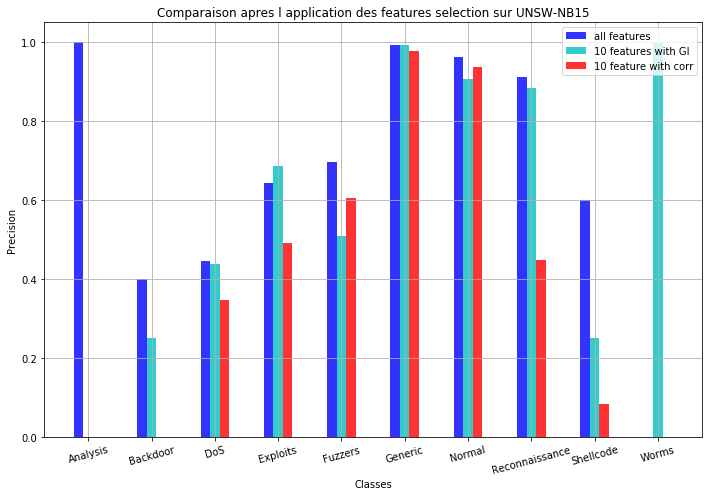

In [3]:
# data to plot
n_groups = 10
# create plot
fig, ax = plt.subplots(figsize=(10,7))
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8
precision_all_RF=[1.  ,       0.4   ,     0.44622426 ,0.64233577, 0.69628433 ,0.9939792,
 0.96186218 ,0.91272727, 0.6   ,     0.        ]

precision_10_GI=[0. ,        0.25    ,   0.43875278, 0.68554007 ,0.5101626 , 0.99253731,
 0.9061152,  0.88448845 ,0.25 ,      1.        ]
precision_10_corr=[0.   ,      0.    ,     0.34791667 ,0.49248748 ,0.605  ,    0.97693133,
 0.93748344, 0.44932432, 0.08333333, 0.        ]

rects1 = plt.bar(index, precision_all_RF, bar_width,
alpha=opacity,
color='b',
label='all features')

#rects2 = plt.bar(index + bar_width, precision_score_SVM, bar_width,
#alpha=opacity,
#color='g',
#label='SVM')

rects3 = plt.bar(index+ bar_width, precision_10_GI, bar_width,
alpha=opacity,
color='c',
label='10 features with GI')

rects4 = plt.bar(index + 2*bar_width, precision_10_corr, bar_width,
alpha=opacity,
color='r',
label='10 feature with corr')




plt.xlabel('Classes')
plt.ylabel('Precision')
plt.title('Comparaison apres l application des features selection sur UNSW-NB15')
plt.xticks(index + bar_width, ('Analysis','Backdoor', 'DoS', 'Exploits', 'Fuzzers','Generic', 'Normal', 'Reconnaissance', 'Shellcode','Worms'),rotation='15')
plt.legend()

plt.tight_layout()
plt.grid()

In [ ]:
Time coor:  1422.4937598705292
Time GI:  2238.213027238846
Time all:  10482.915075540543
    
Acc coor:  80
Acc GI:  84
ACC all:  87
    
corr: Index(['sttl', 'state', 'ct_dst_sport_ltm', 'ct_src_dport_ltm', 'rate',
       'ct_state_ttl', 'ct_srv_dst', 'ct_srv_src', 'ct_dst_src_ltm',
       'ct_src_ltm'],
      dtype='object')
    
GI: 
sbytes            
smean              
sload              
dbytes             
ct_state_ttl       
rate               
dur                
dmean              
dttl               
dinpkt    

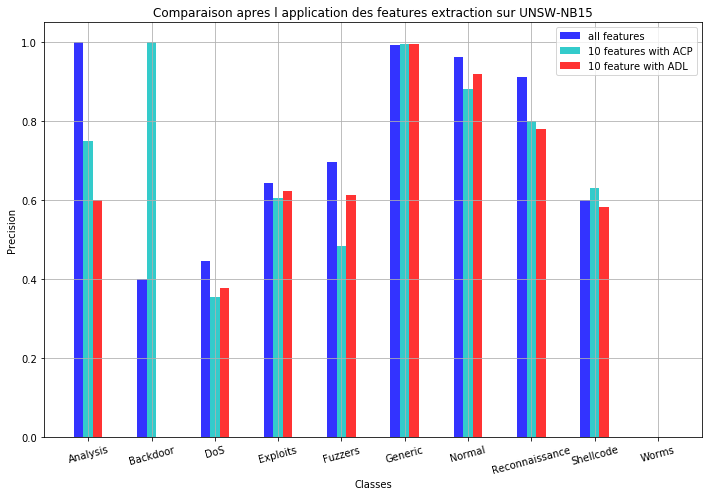

In [19]:
# data to plot
n_groups = 10
# create plot
fig, ax = plt.subplots(figsize=(10,7))
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8
precision_all_RF=[1.  ,       0.4   ,     0.44622426 ,0.64233577, 0.69628433 ,0.9939792,
 0.96186218 ,0.91272727, 0.6   ,     0.        ]

precision_10_ACP=[0.75 ,      1.     ,    0.3556701,  0.60652921, 0.48372093, 0.99571275,
 0.88096988, 0.79928315, 0.63157895, 0.        ]
precision_10_ADL=[0.6 ,       0.  ,       0.37717122, 0.6222935 , 0.61262799, 0.99559471,
 0.91818883 ,0.77978339 ,0.58333333, 0.        ]

rects1 = plt.bar(index, precision_all_RF, bar_width,
alpha=opacity,
color='b',
label='all features')

#rects2 = plt.bar(index + bar_width, precision_score_SVM, bar_width,
#alpha=opacity,
#color='g',
#label='SVM')

rects3 = plt.bar(index+ bar_width, precision_10_ACP, bar_width,
alpha=opacity,
color='c',
label='10 features with ACP')

rects4 = plt.bar(index + 2*bar_width, precision_10_ADL, bar_width,
alpha=opacity,
color='r',
label='10 feature with ADL')




plt.xlabel('Classes')
plt.ylabel('Precision')
plt.title('Comparaison apres l application des features extraction sur UNSW-NB15')
plt.xticks(index + bar_width, ('Analysis','Backdoor', 'DoS', 'Exploits', 'Fuzzers','Generic', 'Normal', 'Reconnaissance', 'Shellcode','Worms'),rotation='15')
plt.legend()

plt.tight_layout()
plt.grid()